# Hazard: Landslides

## Landslide class
The landslide class inherits from the hazard class and simulates landslides. 
It handles 3 different models: 
* LS_MODEL[0]: hist_NASA_COOLR - a global historic one, based on the NASA COOLR global landslide catalogue, continuously updated.
* LS_MODEL[1]: prob_UNEP_NGI - a global probabilistic one, based on the Norwegian Geotechnical Institute (NGI) for UNEP GRID, last improved 2018.
* (LS_MODEL[2]: prob_NASA_NOW - a global probabilistic one based on NASA landslide nowcasting, continously updated (monthly and daily versions); currently not recommended).

### LS_MODEL[1]: prob_UNEP_NGI

1) Download the raw data from from https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=2&lang=eng

2) Unzip it, to get a .tif and a .tfw file. 

3) It first needs to be converted to a GeoTiff file (> 1 GB, therefore not provided directly on GitHub):
  * Option 1: Open the file in QGis and export the layer as GeoTiff (right-click the layer -> export-.> save as GeoTiff -> make sure the extent matches the current layer extent).
  * Option 2: Open a terminal. Type in *source activate climada_env* then *gdal_translate filepath_to_tif.tif filepath_to_new_geotif.tif* . It automatically creates a GeoTiff file.

4) Save the file in ~/climada_python/data/system/ls_pr_geotagged_masked_global.tif (exactly like that!)


The global dataset has units of expected annual probability and percentage of pixel of occurrence of a potentially destructive landslide event x 1000000 and includes an estimate of the annual frequency of landslide triggered by precipitations. It depends on the combination of trigger and susceptibility defined by six parameters: slope factor, lithological (or geological) conditions, soil moisture condition, vegetation cover, precipitation and seismic conditions.

For the CLIMADA hazard set, the occurrence probabilities for each pixel of the raw dataset are converted into binary events. Where a landslide occurs is determined  based on a binomial distribution with p = probability of LS occurrence in the respective pixel and n = number of years in the simulation.

In [1]:
%matplotlib inline
from climada.hazard import Hazard
from climada.hazard import landslide
from climada.hazard.landslide import Landslide
import os

2019-07-31 21:14:59,929 - climada - DEBUG - Loading default config file: /Users/evelynm/climada_python/climada/conf/defaults.conf


2019-07-31 21:15:05,440 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/system/ls_pr_geotagged_masked_global.tif
2019-07-31 21:15:05,679 - climada.hazard.landslide - INFO - Generating landslides...


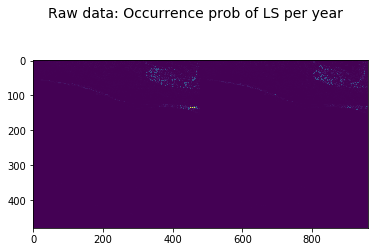

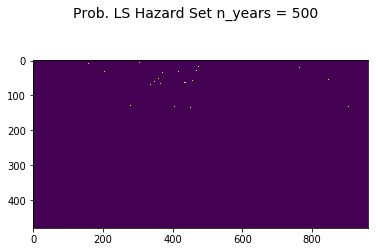

In [2]:
haz_ls_Nepal = Landslide()
haz_ls_Nepal.set_LS_model(n_years = 500, ls_model = landslide.LS_MODEL[1], bbox=[30.0, 88.0, 26.0, 80.0], path_sourcefile = landslide.PATH_LS_NGI_UNEP, check_plots=1)

When putting *incl_neighbour=True* and a corresponding *max_dist = (dist in metres)*, the model also counts the neighbouring pixels up to the max_dist as affected, scaled down linearly.

2019-08-01 12:05:54,940 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/system/ls_pr_geotagged_masked_global.tif
2019-08-01 12:05:55,208 - climada.hazard.landslide - INFO - Generating landslides...
2019-08-01 12:06:22,962 - climada.hazard.landslide - INFO - Finding neighbouring pixels...
2019-08-01 12:06:22,969 - climada.hazard.centroids.centr - INFO - Setting geometry points.


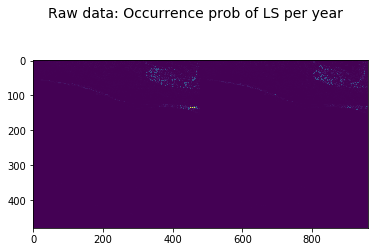

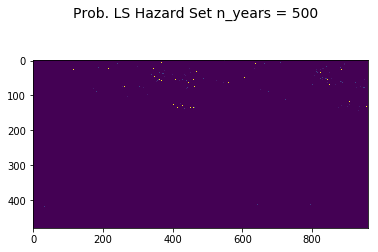

In [5]:
haz_ls_Nepal_neighbours = Landslide()
# The following calculation may take a while (few minutes)
haz_ls_Nepal_neighbours.set_LS_model(n_years = 500, ls_model = landslide.LS_MODEL[1], bbox=[30, 88, 26, 80], path_sourcefile = landslide.PATH_LS_NGI_UNEP, incl_neighbour = True, max_dist = 1000, check_plots=1)

With the hazard set defined, it is now possible to calculate the expected damage for the simulated period:

In [6]:
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

2019-08-01 12:34:43,609 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2019-08-01 12:34:43,612 - climada.entity.exposures.nightlight - DEBUG - Found all required satellite data (1 files) in folder /Users/evelynm/climada_python/data/system
2019-08-01 12:34:43,613 - climada.entity.exposures.litpop - DEBUG - Importing /Users/evelynm/climada_python/data/system/BlackMarble_2016_C1_geo_gray.tif.
2019-08-01 12:35:00,855 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2019-08-01 12:35:00,857 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2019-08-01 12:35:00,858 - climada.entity.exposures.gpw_import - DEBUG - Importing /Users/evelynm/climada_python/data/system/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif
2019-08-01 12:35:21,848 - climada.util.finance - INFO - GDP NPL 2014: 2.000e+10.
2019-08-01 12:35:2

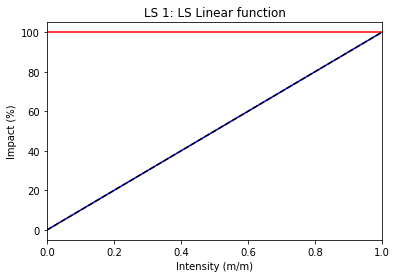

In [7]:
# Set impact function
if_LS_test = ImpactFunc() 
if_LS_test.haz_type = 'LS'
if_LS_test.id = 1
if_LS_test.name = 'LS Linear function'
if_LS_test.intensity_unit = 'm/m'
if_LS_test.intensity = np.linspace(0, 1, num=15)
if_LS_test.mdd = np.sort(np.linspace(0, 1, num=15))
if_LS_test.paa = np.sort(np.linspace(1, 1, num=15))
if_LS_test.check()
if_LS_test.plot()
ifset_LS_test = ImpactFuncSet()
ifset_LS_test.append(if_LS_test)

# Set exposure:
exp_LS_test = LitPop()
exp_LS_test.set_country('Nepal')
exp_LS_test.set_geometry_points()
exp_LS_test.rename({'if_': 'if_LS'}, axis='columns')
exp_LS_test = Exposures(exp_LS_test)
exp_LS_test.set_lat_lon()
exp_LS_test.check()

# Set Entity    
ent_LS_test = Entity()
ent_LS_test.exposures = exp_LS_test
ent_LS_test.impact_funcs = ifset_LS_test

2019-08-01 13:02:35,237 - climada.entity.exposures.base - INFO - Matching 194808 exposures with 460800 centroids.
2019-08-01 13:02:35,268 - climada.engine.impact - INFO - Calculating damage for 185460 assets (>0) and 1 events.
2019-08-01 13:02:35,270 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2019-08-01 13:02:35,354 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333325754 to 0.008333333333325754.


/Users/evelynm/anaconda3/envs/climada_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


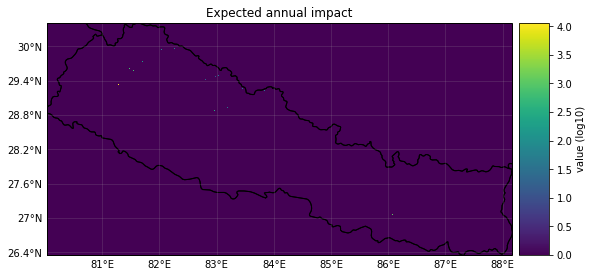

In [8]:
# Set impact for probabilistic simulation
imp_LS_Nepal_prob = Impact()
imp_LS_Nepal_prob.calc(ent_LS_test.exposures, ent_LS_test.impact_funcs, haz_ls_Nepal)
imp_LS_Nepal_prob.plot_raster_eai_exposure()

2019-07-11 15:04:22,662 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LS
2019-07-11 15:04:22,667 - climada.engine.impact - INFO - Calculating damage for 185460 assets (>0) and 1 events.
2019-07-11 15:04:22,668 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2019-07-11 15:04:22,726 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2019-07-11 15:04:22,727 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2019-07-11 15:04:22,727 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2019-07-11 15:04:22,728 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2019-07-11 15:04:22,732 - climada.entity.exposures.base - INFO - centr_ not set.
2019-07-11 15:04:22,733 - climada.entity.exposures.base - INFO - deductible not set.
2019-07-11 15:04:22,734 -

(<Figure size 648x936 with 2 Axes>,
 array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x1c463c9e10>]],
       dtype=object))

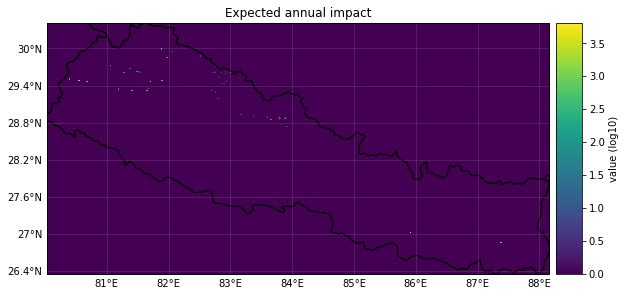

In [9]:
# Set impact for probabilistic simulation incl. neighbours
imp_LS_Nepal_neighbours = Impact()
imp_LS_Nepal_neighbours.calc(ent_LS_test.exposures, ent_LS_test.impact_funcs, haz_ls_Nepal_neighbours)
imp_LS_Nepal_neighbours.plot_raster_eai_exposure()

Last remark: Be aware that this is the expected impact for the whole simulation period (not annually)!

### LS-model[0]: hist_NASA_COOLR
Data from the global landslide catalogue is continuously updated as part of the Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download). Therefore, the most recent version of the dataset should always be downloaded by going to the link > "Open Landslide Viewer" (takes some time to load) > click "Download the full Landslide Catalog" > selecting the "NASA Global Landslide Catalog Points (Shapefile)" for download.

The historic landslide events are then directly read into a landslide hazard set.

In [ ]:
# Download up-to-date version, unzip and store in reasonable place


2019-08-01 13:03:08,596 - climada.util.checker - DEBUG - Hazard.event_name not set. Default values set.
2019-08-01 13:03:08,596 - climada.util.checker - DEBUG - Hazard.date not set. Default values set.


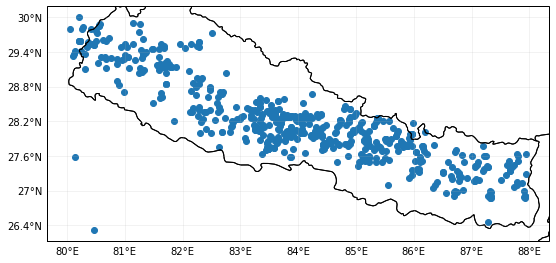

In [9]:
# Read into Landslide hazard set:

haz_ls_Nepal_hist = Landslide()
path_COOLR = 'your/path/to/nasa_global_landslide_catalog_point.shp'
haz_ls_Nepal_hist.set_LS_model(ls_model=landslide.LS_MODEL[0],  bbox=[30.0, 88.0, 26.0, 80.0], path_sourcefile = path_COOLR, check_plots=1)


The impact calculation follows as in the first example:

In [10]:
# Impact from historic landslides, with exposure and impact function defined as above.
imp_LS_Nepal_hist = Impact()
imp_LS_Nepal_hist.calc(ent_LS_test.exposures, ent_LS_test.impact_funcs, haz_ls_Nepal_hist)
imp_LS_Nepal_hist.plot_raster_eai_exposure()

2019-08-01 13:03:27,034 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LS
2019-08-01 13:03:27,042 - climada.engine.impact - INFO - Calculating damage for 185460 assets (>0) and 584 events.
2019-08-01 13:03:27,043 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.


IndexError: index (420398) out of range

### LS_MODEL[2]: prob_NASA_NOW
Since these datasets are updated contiously, it makes sense to retrieve the most recent versions first and combine them into one dataset. 

Global raw data on daily hazard levels (0-2) can be downloaded for a maximum amount of 90 prior days via an API request from the PMM website of NASA (https://pmmpublisher.pps.eosdis.nasa.gov). They are constructed by combining a landslide susceptibility map (same one as used in the probabilistic model above) with 7 day up to date precipitation data. 

Global raw data exists also monthly (Jan-Dec), each containing averages over the last 15 years, combining again susceptibility and precipitation factors. They can also be downloaded with an API request from the NASA frames files website (https://svs.gsfc.nasa.gov/vis/a000000/a004600/a004631/frames/9600x5400_16x9_30p/MonthlyClimatology/ )


In [13]:
# Daily data for the last 90 days (takes a while!! adjust start and end-time or just skip this step)
landslide.get_nowcast_tiff(tif_type = "daily", startTime = "2019-05-01", endTime = "2019-07-11", save_path = os.getcwd()+'/results/')

requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/192/global_landslide_nowcast_20190711.tif
downloading content...
requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/134/global_landslide_nowcast_20190514.tif
downloading content...
requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/189/global_landslide_nowcast_20190708.tif
downloading content...
requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/187/global_landslide_nowcast_20190706.tif
downloading content...
requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/188/global_landslide_nowcast_20190707.tif
downloading content...
requesting https://pmmpublisher.pps.eosdis.nasa.gov/products/s3/Global/global_landslide_nowcast/2019/185/global_landslide_nowcast_20190704.tif
downloading content...
requ

downloading content...


Once downloaded, the daily hazard maps can then be combined by merging them into one hazard map, either keeping the highest values for each pixel (operator = "maximum"), or by summing up all values of all days (operator = "sum").
The output is stored in the folder as combined_nowcasts_LS.tif

In [14]:
# Combine by maximum (make sure LS_folder_path is the one where you just downloaded daily LS data to!)
# also this step takes a while
# if you skipped the prior step, also skip this combination step 
landslide.combine_nowcast_tiff(LS_folder_path = os.getcwd()+'/results', search_criteria = 'LS*.tif', operator = "maximum")

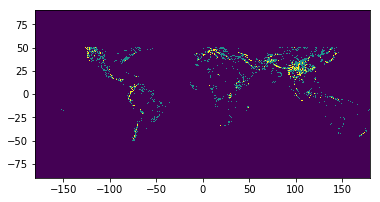

In [18]:
# Plot combined daily LS nowcasts
import rasterio
from rasterio.plot import show
LS_daily_nowcast_combined = rasterio.open(os.getcwd()+'/results/' + 'combined_nowcasts_LS.tif')

# or, if you skipped the previous steps, load from demo folder:
#from climada.util.constants import DATA_DIR
#LS_daily_nowcast_combined = rasterio.open(DATA_DIR + '/demo/combined_nowcasts_daily_LS.tif')
show(LS_daily_nowcast_combined)

Same for the monthly aggregated data ...

In [3]:
# Monthly data (Jan-Dec) averaged over the last 15 years (named [01-12]_ClimatologyMonthly_032818_9600x5400)
landslide.get_nowcast_tiff(tif_type = "monthly")


In [9]:
# Combine monthly data by summing images (else could also be used individually to create "monthly" hazard maps!)
landslide.combine_nowcast_tiff(LS_folder_path = os.getcwd()+'/', search_criteria = '*5400.tif', operator = "sum")

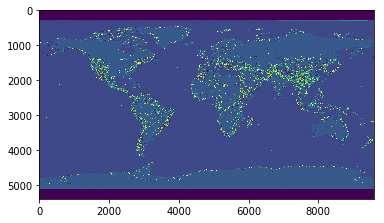

In [10]:
import rasterio
from rasterio.plot import show
LS_monthly_nowcast_combined = rasterio.open(os.getcwd()+'/combined_nowcasts_LS.tif')
show(LS_monthly_nowcast_combined)

Both the daily and the monthly hazard maps do not have probabilities of occurrence but categories. Therefore, categories first have to be converted into occurrence probabilities. For now, this is arbitrary as the highest category value is allocated an arbitrary probability (0.000015 here). It should be inquired at the NASA landslide info address what the categories refer to.
The remaining calculations are then the same as in the above probabilistic model (probability into acutal binary occurrences, formatting into climada hazard set).

2019-07-12 20:07:20,146 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/doc/tutorial/results/combined_nowcasts_LS.tif
Setting probability values for categorical landslide hazard level...
Generating binary landslides...


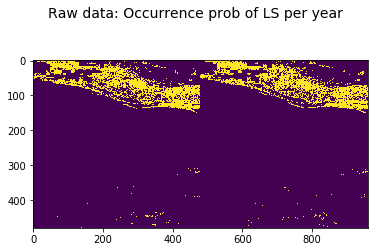

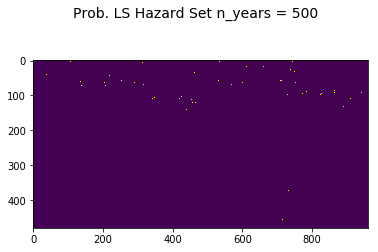

In [3]:
# Take the combined daily nowcast data as input file, 500y simulation, max prob value = 0.000015
haz_ls_Nepal_now = Landslide()
path_daily_combined = os.getcwd()+'/results/' + 'combined_nowcasts_LS.tif'
haz_ls_Nepal_now.set_LS_model(n_years = 500, ls_model = landslide.LS_MODEL[2], path_sourcefile = path_daily_combined, bbox=[30, 88, 26, 80], incl_neighbour = False, max_prob = 0.000015, check_plots=1)

The impact calculation would follow exactly as demonstrated above.